In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from fiona.crs import from_epsg

import os
import urllib
import requests

import matplotlib.pyplot as plt

%matplotlib inline

*DataSource*

1. BuildingFootprint:
https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
2. Pluto Dataset:
https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
3. Rolling Sale Update(Apr 2018 - Mar 2019)
https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page
4. Annualized Rolling Sales Update(2003-2018)
https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page

# Data processing

## pluto dataset

_pluto data_
link: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

_pluto dictionary_
link: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=18v21beta

In [2]:
pluto = pd.read_csv('data/pluto_18v2_1.csv')
pluto.bbl = pluto.bbl.astype(str)
pluto.bbl = [pluto.bbl[i].split('.')[0] for i in range(pluto.shape[0])]

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (16,17,18,20,22,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pluto.address.isnull().sum()

528

In [4]:
len(pluto.bbl.unique())

858977

## Census block boundary

In [5]:
cb_shapefile = gpd.read_file('data/2010 Census Blocks.geojson').to_crs(fiona.crs.from_epsg(2263))
cb_shapefile.head()

,shape_area,cb2010,bctcb2010,shape_leng,boro_name,ct2010,boro_code,geometry
0,244589.603884,1000,50009001000,2508.94811457,Staten Island,000900,5,(POLYGON ((962269.1260375973 173705.5001830565...
1,111006.286826,1000,50020011000,1345.88642172,Staten Island,002001,5,"(POLYGON ((964642.267639162 161835.2651977026,..."
2,150406.766022,1000,50027001000,1703.38117241,Staten Island,002700,5,(POLYGON ((963363.1168212886 167356.3336181112...
3,141296.561149,1000,50040001000,1511.17374266,Staten Island,004000,5,(POLYGON ((960069.9965820297 161953.6936034636...
4,200784.983607,1000,50064001000,1978.24385199,Staten Island,006400,5,(POLYGON ((963023.8917846683 158246.7521972068...


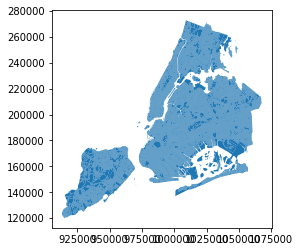

In [6]:
cb_shapefile.plot()

In [7]:
# the logic is bctcb2010 = boro_code+ct2010+cb2010

In [8]:
# total 38796 census blocks 
len(cb_shapefile.bctcb2010.unique())

38796

In [9]:
len(cb_shapefile[cb_shapefile['boro_code']=='1'])

3858

In [10]:
len(pluto.bbl.unique())

858977

In [11]:
len(pluto.bbl)

858982

## Building Footprint Shapefile

In [12]:
## run once
# url = "https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=GeoJSON"
# filename = "buildingfootprint.geojson"
# urllib.request.urlretrieve(url,filename)
# !mv buildingfootprint.geojson InputData
# take 32min

In [13]:
!ls data

2010 Census Blocks.geojson
BBL
BBL.gz
IsoForestData.csv
IsoForestData_z.csv
OneClassSVMData.csv
OneClassSVMData_z.csv
data_train.csv
output.csv
pluto_18v2_1.csv
saleData
sale_manhattan.png


In [14]:
# data dictionary 
# link: https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md

In [15]:
if not os.path.isfile("data/BBL.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "BBL.gz")
    !mv BBL.gz data
    !unzip -o data/BBL.gz -d data/BBL
else:
    print("file in place, you can continue")

file in place, you can continue


In [16]:
filename = ! ls data/BBL | grep .shp
BBL = gpd.GeoDataFrame.from_file('data/BBL/' + filename[1])
# BBL = BBL[CensusTracts['boro_name']=='Manhattan']
print(BBL.shape)
BBL.head()

(1084108, 16)


,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,geometry
0,3044520815,3394646.0,2009.0,1212853.0,2100.0,Photogramm,18.0,21.608508,2017-08-22,00:00:00.000,Constructed,3044520815,None,854.662433,125.079796,POLYGON ((-73.87129515296562 40.65717370043455...
1,4030640041,4548330.0,1930.0,1226227.0,5110.0,Photogramm,122.0,10.360000,2017-08-17,00:00:00.000,Constructed,4030640041,None,217.594243,60.225858,POLYGON ((-73.87670970144625 40.71425234541623...
2,4139430001,4460479.0,1960.0,581946.0,2100.0,Photogramm,10.0,29.811570,2017-08-22,00:00:00.000,Constructed,4139430001,None,946.427476,123.141941,"POLYGON ((-73.85195485799383 40.6623547177829,..."
3,3049720006,3355684.0,1920.0,858061.0,5110.0,Photogramm,32.0,11.200000,2017-08-17,00:00:00.000,Constructed,3049720006,None,248.678169,63.940817,POLYGON ((-73.94029215265738 40.64108287979622...
4,3055100055,3131737.0,1915.0,568078.0,2100.0,Photogramm,44.0,24.980000,2017-08-22,00:00:00.000,Constructed,3055100055,None,1163.227669,165.608763,POLYGON ((-73.98998983552244 40.62383804513802...


In [18]:
# BBL.plot()

## Rolling Sale data

_Rolling Sales - last 12 months (New York City Sales Data
from April 2018 to March 2019) for all tax classes, sorted by borough and block_

link: https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

{MN:1,BX:2.BK:3,QN:4,SI:5}

**issue: for SALE PRICE lower than specific amount (e.g. 1 or 2500), it could be bias for the model. Check the link below**
link: https://www.trulia.com/voices/Home_Selling/why_do_some_transactions_in_eg_show_sale_-274151

In [19]:
mnsale = pd.read_excel(r'data/saleData/rollingsales_manhattan.xls')
mnsale.columns = mnsale.iloc[3,:]
mnsale = mnsale.iloc[4:,:].reset_index(drop = True)

bxsale = pd.read_excel(r'data/saleData/rollingsales_bronx.xls')
bxsale.columns = bxsale.iloc[3,:]
bxsale = bxsale.iloc[4:,:].reset_index(drop = True)

bksale = pd.read_excel(r'data/saleData/rollingsales_brooklyn.xls')
bksale.columns = bksale.iloc[3,:]
bksale = bksale.iloc[4:,:].reset_index(drop = True)

qnsale = pd.read_excel(r'data/saleData/rollingsales_queens.xls')
qnsale.columns = qnsale.iloc[3,:]
qnsale = qnsale.iloc[4:,:].reset_index(drop = True)

sisale = pd.read_excel(r'data/saleData/rollingsales_statenisland.xls')
sisale.columns = sisale.iloc[3,:]
sisale = sisale.iloc[4:,:].reset_index(drop = True)

In [20]:
sale = pd.concat([mnsale,bxsale,bksale,qnsale,sisale],axis = 0).reset_index(drop = True)
sale.head()

3,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1,0,1,987,2183,1860,1,A4,4844809,2018-05-22 00:00:00
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1,0,1,987,2183,1860,1,A4,0,2018-05-23 00:00:00
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,NaN,A4,526 EAST 5TH STREET,NaN,...,1,0,1,1883,5200,1900,1,A4,6100000,2018-12-03 00:00:00
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,NaN,B1,113 AVENUE C,NaN,...,2,0,2,1218,4764,1899,1,B1,0,2018-04-25 00:00:00
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,NaN,B9,166 AVENUE A,NaN,...,2,0,2,1510,4520,1900,1,B9,0,2018-11-29 00:00:00


In [21]:
len(sale)

81126

In [22]:
len(sale.columns)

21

In [23]:
sale.iloc[:,:12].head(2)

3,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,10009,1
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,10009,1


In [24]:
sale.iloc[:,12:].head(2)

3,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,0,1,987,2183,1860,1,A4,4844809,2018-05-22 00:00:00
1,0,1,987,2183,1860,1,A4,0,2018-05-23 00:00:00


In [25]:
sale.dtypes

3
BOROUGH                           object
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                             object
LOT                               object
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                          object
RESIDENTIAL UNITS                 object
COMMERCIAL UNITS                  object
TOTAL UNITS                       object
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                        object
TAX CLASS AT TIME OF SALE         object
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [26]:
sale.isnull().sum()

3
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                 45
BLOCK                                 0
LOT                                   0
EASE-MENT                         81126
BUILDING CLASS AT PRESENT            45
ADDRESS                               0
APARTMENT NUMBER                  63324
ZIP CODE                              2
RESIDENTIAL UNITS                    45
COMMERCIAL UNITS                     45
TOTAL UNITS                          45
LAND SQUARE FEET                     76
GROSS SQUARE FEET                    45
YEAR BUILT                           28
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64

In [27]:
#1. SALE PRICE should not be 0 or NaN
#2. Sort by SALE DATE and get the latest sale price
sale = sale[sale['SALE PRICE']!=0].reset_index(drop = True)


In [28]:
# create column bbl
sale['bbl']  = [str(sale['BOROUGH'][i]).zfill(1)+str(sale['BLOCK'][i]).zfill(5)+str(sale['LOT'][i]).zfill(4) for i in range(sale.shape[0])]

In [29]:
sale.sort_values('SALE DATE',ascending= False,inplace= True)
sale.reset_index(drop =True,inplace = True)

In [30]:
def intersection(lst1, lst2): 
    return len(list(set(lst1) & set(lst2)))
print(intersection(sale.bbl.tolist(),pluto.bbl.tolist()))

32241


In [31]:
salemerge = sale.merge(pluto,how = 'inner',left_on = 'bbl',right_on = 'bbl')

In [32]:
salemerge.cb2010 = [str(salemerge.cb2010[i]).split('.')[0] for i in range(salemerge.shape[0])]

In [33]:
#{MN:1,BX:2.BK:3,QN:4,SI:5}
for i in range(1,6):
    print(len(salemerge[salemerge['BOROUGH']==i].bbl))

6656
4983
10627
15338
5394


In [34]:
#{MN:1,BX:2.BK:3,QN:4,SI:5}
for i in range(1,6):
    print(len(salemerge[salemerge['BOROUGH']==i].bbl.unique()))

2805
3969
8778
11533
5156


In [35]:
for i in range(1,6):
    print(len(pluto[pluto.borocode==i].bbl.unique()))

42897
89825
277028
324554
124672


In [36]:
len(salemerge[salemerge['BOROUGH']==1].bbl)

6656

In [39]:
# density of sale in map 

# Data Wrangling using only mahattan data

In [37]:
mn_salemerge = salemerge[salemerge.borocode==1].reset_index(drop = True)

In [38]:
mn_cb = cb_shapefile[cb_shapefile.boro_code=='1'].reset_index(drop = True)

In [39]:
len(mn_salemerge)

6656

In [40]:
mn_sale_cb = mn_cb.merge(mn_salemerge,how = 'inner',left_on = 'cb2010',right_on = 'cb2010')

In [41]:
mn_sale_cb.head(2)

,shape_area,cb2010,bctcb2010,shape_leng,boro_name,ct2010_x,boro_code,geometry,BOROUGH,NEIGHBORHOOD,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,57115.9140286,1000,10002021000,1187.88386045,Manhattan,000202,1,(POLYGON ((989804.9920043969 199396.6488036586...,1,GRAMERCY,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
1,57115.9140286,1000,10002021000,1187.88386045,Manhattan,000202,1,(POLYGON ((989804.9920043969 199396.6488036586...,1,GRAMERCY,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018


In [42]:
# join the bbl shapefile with sale

In [43]:
BBL.head(2)

,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,geometry
0,3044520815,3394646.0,2009.0,1212853.0,2100.0,Photogramm,18.0,21.608508,2017-08-22,00:00:00.000,Constructed,3044520815,None,854.662433,125.079796,POLYGON ((-73.87129515296562 40.65717370043455...
1,4030640041,4548330.0,1930.0,1226227.0,5110.0,Photogramm,122.0,10.360000,2017-08-17,00:00:00.000,Constructed,4030640041,None,217.594243,60.225858,POLYGON ((-73.87670970144625 40.71425234541623...


In [44]:
len(BBL.base_bbl.unique())

816896

In [45]:
mn_sale_bbl = BBL.merge(mn_salemerge,how = 'inner',left_on = 'base_bbl',right_on = 'bbl')

In [46]:
mnBBL = BBL[[BBL.base_bbl[i][0]=='1' for i in range(BBL.shape[0])]]

In [47]:
mnBBL.reset_index(drop = True,inplace = True)

## feature Selection

In [49]:
# change build year as building Age
mn_salemerge['YEAR BUILT'] = 2019- mn_salemerge['YEAR BUILT']

In [50]:
print([i for i in mn_salemerge.columns])

['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE', 'bbl', 'borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 

['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE', 'bbl', 'borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exemptland', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'condono', 'tract2010', 'xcoord', 'ycoord', 'zonemap', 'zmcode', 'sanborn', 'taxmap', 'edesignum', 'appbbl', 'appdate', 'mappluto_f', 'plutomapid', 'version', 'sanitdistrict', 'healthcenterdistrict', 'firm07_flag', 'pfirm15_flag', 'rpaddate', 'dcasdate', 'zoningdate', 'landmkdate', 'basempdate', 'masdate', 'polidate', 'edesigdate']


`numeric features`

['YEAR BUILT','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'easements', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth','assessland', 'assesstot', 'exemptland', 'exempttot', 'builtfar', 'residfar', 'commfar', 'facilfar',
'DensityPop', 
'IncomePerCap', 
'Poverty', 
'Professional', 
'Service', 
'Office', 
'Construction', 
'Production', 
'Employed', 
'Unemployment',
'distance_subway',
'distance_bus',
'park_num',
'park_area',
'park_top_level',
'park_distance',
'FELONY',
'VIOLATION',
'MISDEMEANOR',
'Num of SAT Test Takers', 'satReadingSum', 
'satMathSum',
'satWritingSum']


`feature catergorical`

['histdist', 'landmark','landuse']


## SAT: add SAT  combine sat score using schoolDist  

In [54]:
sat = pd.read_csv('data/school_sat.csv',index_col= False)
sat.head()

,Unnamed: 0,DBN,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,School_District,geometry
0,0,01M292,29,355,404,363,1.0,"POLYGON ((992073.466796875 203714.0759887695, ..."
1,1,01M448,91,383,423,366,1.0,"POLYGON ((992073.466796875 203714.0759887695, ..."
2,2,01M450,70,377,402,370,1.0,"POLYGON ((992073.466796875 203714.0759887695, ..."
3,3,01M458,7,414,401,359,1.0,"POLYGON ((992073.466796875 203714.0759887695, ..."
4,4,01M509,44,390,433,384,1.0,"POLYGON ((992073.466796875 203714.0759887695, ..."


In [55]:
sat.dropna(inplace =True)
sat = sat[sat['SAT Math Avg. Score']!='s']
sat['Num of SAT Test Takers'] = sat['Num of SAT Test Takers'].astype(int)
sat['SAT Critical Reading Avg. Score'] = sat['SAT Critical Reading Avg. Score'].astype(float)
sat['SAT Math Avg. Score'] = sat['SAT Math Avg. Score'].astype(float)
sat['SAT Writing Avg. Score'] = sat['SAT Writing Avg. Score'].astype(float)
sat['satReadingSum'] = sat['SAT Critical Reading Avg. Score']*sat['Num of SAT Test Takers']
sat['satMathSum'] = sat['SAT Math Avg. Score']*sat['Num of SAT Test Takers']
sat['satWritingSum'] = sat['SAT Writing Avg. Score']*sat['Num of SAT Test Takers']

In [56]:
sat2 = sat.groupby('School_District').sum()

In [57]:
sat_schoolDist = sat.groupby('School_District',as_index = False).sum()[['School_District']+['Num of SAT Test Takers']+sat2.columns[-3:].tolist()]
sat_schoolDist

,School_District,Num of SAT Test Takers,satReadingSum,satMathSum,satWritingSum
0,1.0,7053,3066436.0,3242278.0,3035826.0
1,2.0,9100,4099730.0,4333564.0,4071794.0
2,3.0,3825,1904035.0,2009896.0,1898241.0
3,4.0,3655,1506559.0,1598775.0,1483488.0
4,5.0,2850,1229809.0,1309420.0,1217543.0
5,6.0,4005,1765785.0,1952177.0,1768858.0


In [58]:
sat_schoolDist.satReadingSum = round(sat_schoolDist.satReadingSum/sat_schoolDist['Num of SAT Test Takers'],0)
sat_schoolDist.satMathSum = round(sat_schoolDist.satMathSum/sat_schoolDist['Num of SAT Test Takers'],0)
sat_schoolDist.satWritingSum = round(sat_schoolDist.satWritingSum/sat_schoolDist['Num of SAT Test Takers'],0)

In [59]:
sat_schoolDist.head()

,School_District,Num of SAT Test Takers,satReadingSum,satMathSum,satWritingSum
0,1.0,7053,435.0,460.0,430.0
1,2.0,9100,451.0,476.0,447.0
2,3.0,3825,498.0,525.0,496.0
3,4.0,3655,412.0,437.0,406.0
4,5.0,2850,432.0,459.0,427.0


In [60]:
# merge sat with mn_salemerge
mn_salemerge = mn_salemerge.merge(sat_schoolDist,left_on = 'schooldist',right_on = 'School_District')
len(mn_salemerge)

6646

In [ ]:
mn_salemerge.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,landmkdate,basempdate,masdate,polidate,edesigdate,School_District,Num of SAT Test Takers,satReadingSum,satMathSum,satWritingSum
0,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1444,8,NaN,D4,"315 EAST 69TH STREET, 4L",NaN,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0
1,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1444,8,NaN,D4,"315 EAST 69TH STREET, 10F",NaN,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0
2,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1444,8,NaN,D4,"315 EAST 69TH STREET, 11DE",NaN,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0
3,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1444,8,NaN,D4,"315 EAST 69TH STREET, 11F",NaN,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0
4,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1444,8,NaN,D4,"315 EAST 69TH STREET, 12E",NaN,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0


## join spatial Features

In [61]:
!curl https://raw.githubusercontent.com/JunjieTsai/MLC2019_Project/master/data/output.csv> data/output.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 32 22.0M   32 7415k    0     0  3163k      0  0:00:07  0:00:02  0:00:05 3163k
100 22.0M  100 22.0M    0     0  7866k      0  0:00:02  0:00:02 --:--:-- 7866k


In [62]:
!ls data

2010 Census Blocks.geojson
BBL
BBL.gz
IsoForestData.csv
IsoForestData_z.csv
OneClassSVMData.csv
OneClassSVMData_z.csv
data_train.csv
output.csv
pluto_18v2_1.csv
saleData
sale_manhattan.png
school_sat.csv


In [63]:
# read file from link: https://github.com/JunjieTsai/MLC2019_Project/tree/master/data
addDF = pd.read_csv('data/output.csv', usecols=['DensityPop', 
'IncomePerCap', 
'Poverty', 
'Professional', 
'Service', 
'Office', 
'Construction', 
'Production', 
'Employed', 
'Unemployment',
'distance_subway',
'distance_bus',
'park_num',
'park_area',
'park_top_level',
'park_distance',
'FELONY',
'VIOLATION',
'MISDEMEANOR'])
addDF.head()

,IncomePerCap,Poverty,Professional,Service,Office,Construction,Production,Employed,Unemployment,distance_subway,distance_bus,park_num,park_area,park_top_level,park_distance,FELONY,VIOLATION,MISDEMEANOR,DensityPop
0,88081.0,9.2,67.3,4.4,24.8,0.7,2.9,5333.0,6.7,0.000431,0.001354,1,0.650,1,0.002217,469.0,134.0,741.0,0.004069
1,128063.0,3.8,78.4,4.5,16.3,0.0,0.8,5760.0,4.0,0.003997,0.000763,5,3.002,2,0.001857,269.0,107.0,344.0,0.004675
2,23358.0,32.5,38.3,19.1,27.5,3.2,12.0,1777.0,18.4,0.002309,0.000256,8,181.295,2,0.000263,322.0,169.0,743.0,0.003468
3,19636.0,37.3,34.7,22.7,34.6,3.3,4.8,1640.0,9.2,0.000695,0.000475,12,13.251,2,0.001331,742.0,209.0,1251.0,0.002275
4,89563.0,4.7,75.6,4.9,15.3,2.8,1.5,2980.0,5.0,0.000466,0.000588,7,2.092,2,0.000272,330.0,103.0,479.0,0.001971


In [64]:
# join with mnBBL
print(len(addDF),len(mnBBL))

45590 45590


In [65]:
mnBBLmerge = mnBBL.merge(addDF,left_index = True,right_index = True)

In [66]:
mn_sale_bbl = mnBBLmerge.merge(mn_salemerge,how = 'inner',left_on = 'base_bbl',right_on = 'bbl')

In [67]:
len(mn_sale_bbl)

8885

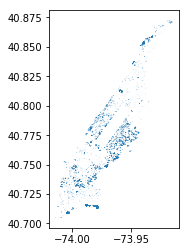

In [68]:
mn_sale_bbl.plot()

In [69]:
mn_sale_bbl.head()

,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,...,landmkdate,basempdate,masdate,polidate,edesigdate,School_District,Num of SAT Test Takers,satReadingSum,satMathSum,satWritingSum
0,1017200108,1053379.0,1909.0,738423.0,2100.0,Photogramm,21.0,46.260000,2017-08-22,00:00:00.000,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,3.0,3825,498.0,525.0,496.0
1,1021230096,1079876.0,1900.0,369103.0,2100.0,Photogramm,145.0,59.655517,2017-08-22,00:00:00.000,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,6.0,4005,441.0,487.0,442.0
2,1021230096,1082447.0,1900.0,520561.0,2100.0,Photogramm,146.0,58.694420,2017-08-22,00:00:00.000,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,6.0,4005,441.0,487.0,442.0
3,1018230058,1055032.0,1920.0,23466.0,2100.0,Photogramm,29.0,75.620000,2017-08-22,00:00:00.000,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,3.0,3825,498.0,525.0,496.0
4,1013880008,1041491.0,1903.0,639733.0,2100.0,Photogramm,65.0,94.380000,2017-08-22,00:00:00.000,...,12/20/2018,12/21/2018,NaN,NaN,12/20/2018,2.0,9100,451.0,476.0,447.0


In [70]:
len(mn_sale_bbl.columns)

157

In [71]:
print([i for i in mn_sale_bbl.columns])

['base_bbl', 'bin', 'cnstrct_yr', 'doitt_id', 'feat_code', 'geomsource', 'groundelev', 'heightroof', 'date_lstmo', 'time_lstmo', 'lststatype', 'mpluto_bbl', 'name', 'shape_area', 'shape_len', 'geometry', 'IncomePerCap', 'Poverty', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Employed', 'Unemployment', 'distance_subway', 'distance_bus', 'park_num', 'park_area', 'park_top_level', 'park_distance', 'FELONY', 'VIOLATION', 'MISDEMEANOR', 'DensityPop', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE', 'bbl', 'borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro'

## Combine all data and add Catergoical data on the back

In [72]:
mn_sale2 = mn_sale_bbl[['SALE PRICE', 'SALE DATE','bbl', 'ct2010', 'cb2010', 'borocode','bldgclass','BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE','firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'sanitdistrict', 'healthcenterdistrict','schooldist','YEAR BUILT','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'easements', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth','assessland', 'assesstot', 'exemptland', 'exempttot', 'builtfar', 'residfar', 'commfar', 'facilfar',
'DensityPop', 
'IncomePerCap', 
'Poverty', 
'Professional', 
'Service', 
'Office', 
'Construction', 
'Production', 
'Employed', 
'Unemployment',
'distance_subway',
'distance_bus',
'park_num',
'park_area',
'park_top_level',
'park_distance',
'FELONY',
'VIOLATION',
'MISDEMEANOR',
'Num of SAT Test Takers', 'satReadingSum', 
'satMathSum',
'satWritingSum','histdist', 'landmark','landuse','geometry']]

In [73]:
mn_sale2.to_csv('data/data_train.csv',index = False)

In [76]:
mnsaleCount = mn_sale2.groupby('bbl',as_index=False).count().iloc[:,:2]
mnsaleCount.columns = ['bbl','SaleCountPerBBL']

In [77]:
bblmncount = mn_sale2.merge(mnsaleCount,how = 'inner',left_on = 'bbl',right_on = 'bbl')

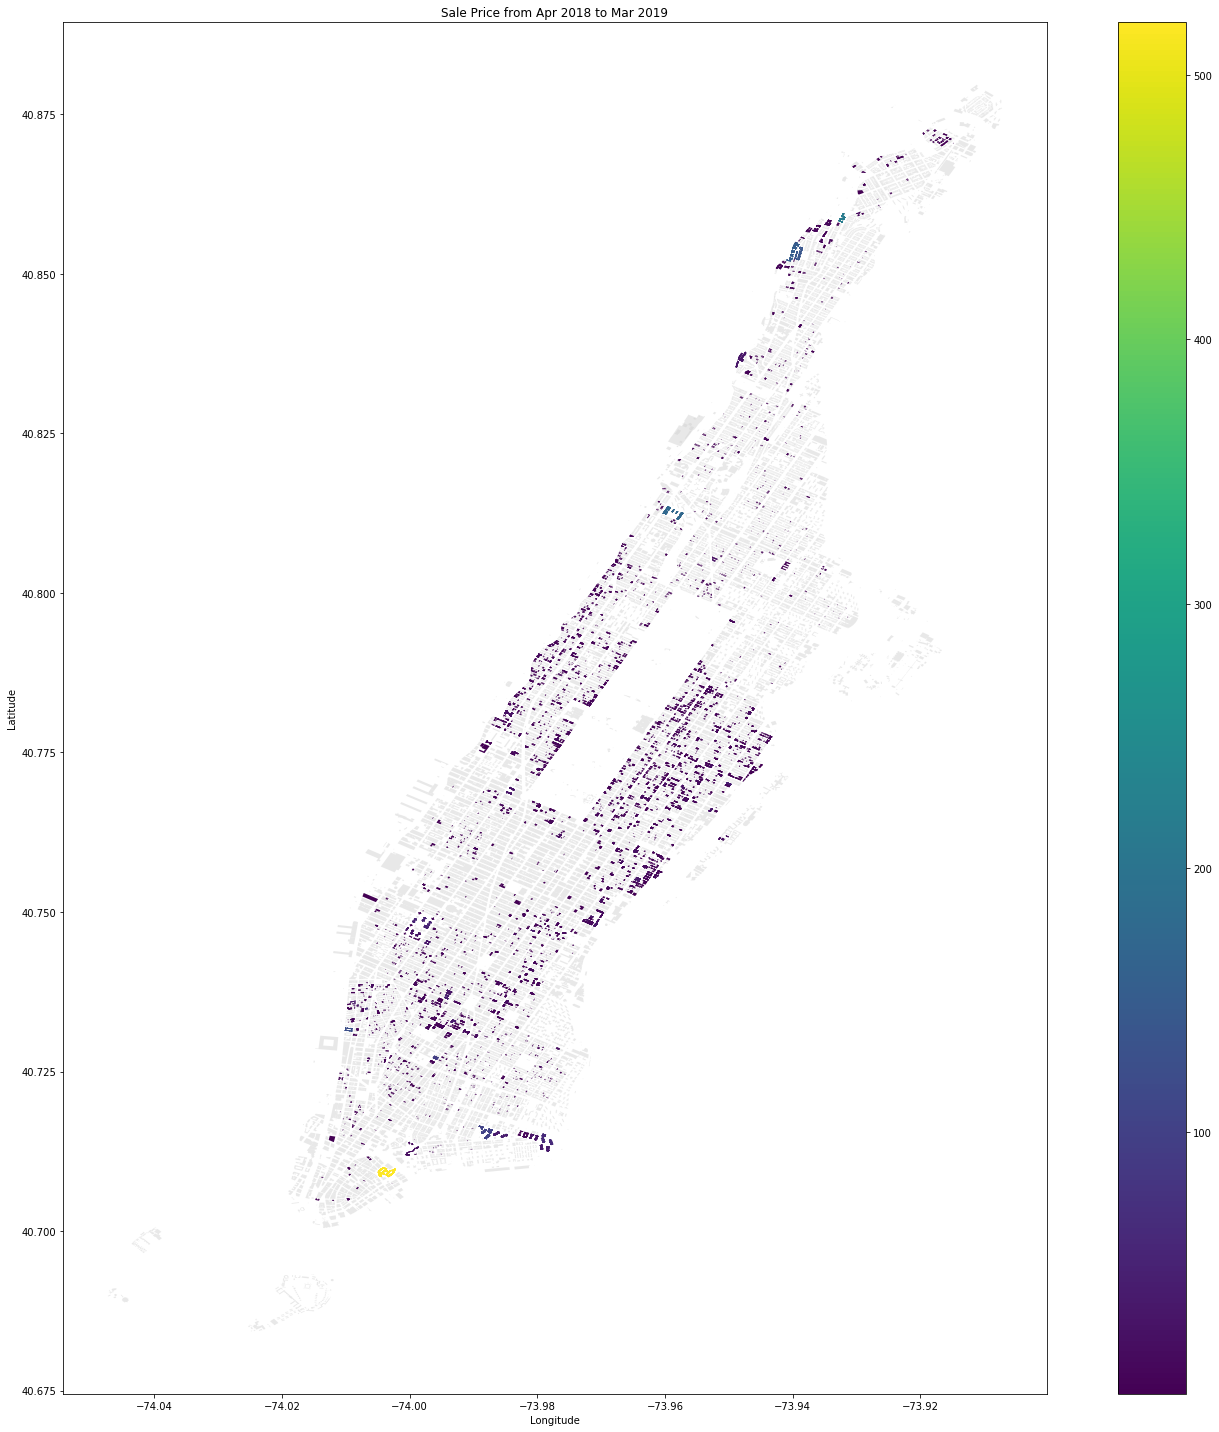

In [79]:
# rerun later
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
mnBBL.plot(ax = ax, color = 'lightgrey',alpha = 0.5)
bblmncount.plot(ax = ax,column= 'SaleCountPerBBL',legend = 'SaleCountPerBBL')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Sale Price from Apr 2018 to Mar 2019')
plt.tight_layout()


# Next Step Data Inspection and Anomaly Detection